In [1]:
%pylab inline
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


Let's generate some data first. We will use a noisy sine.

In [22]:
def gen_data(n=10, sigma_noise=.2, sorted=True):
    X = np.random.rand(1,n) - 0.5
    eps = np.random.randn(1,n) * sigma_noise
    #Y = 0.3 + .7*X -1.1*X**2 + eps
    #Y = np.log(X+1)**.5 + eps
    Y = np.sin(2*pi*X/.5) + eps
    if sorted:
        xind = np.argsort(X[0,:])
        X= X[:,xind]
        Y= Y[:,xind]
    return X,Y

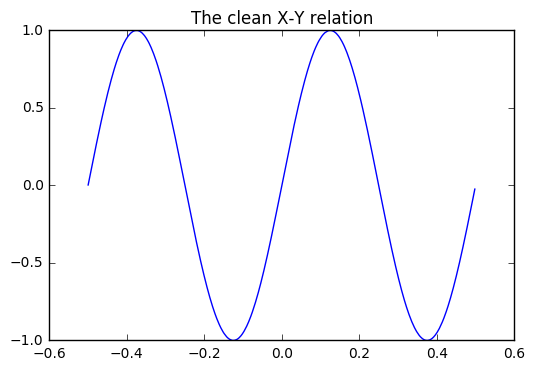

In [23]:
XC,YC = gen_data(n=1000, sigma_noise=0)
fig = plt.figure()
plt.plot(XC.T,YC.T,'-') #note: plot assumes that each column is a data series
plt.title('The clean X-Y relation')
plt.show()

We will be fitting polynomials of various degrees:

In [4]:
def expandX(X, deg=1):
    stack = [X**d for d in xrange(deg+1)]
    return np.vstack(stack)

def polyfit(X,Y, C=0.0):
    theta = npl.inv(X.dot(X.T) + np.eye(X.shape[0])*C).dot(X).dot(Y.T)
    return theta

Fit a few polynomials to the data:

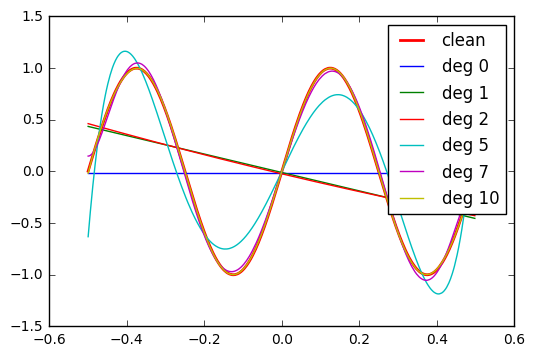

In [24]:
plt.figure()
plt.plot(XC.T,YC.T,'-r', linewidth=2, label='clean')
for deg in [0,1,2,5,7,10]:
    XE = expandX(XC,deg)
    theta = polyfit(XE, YC)
    plt.plot(XC.T, theta.T.dot(XE).T,'-', label='deg %d' % deg, )
plt.legend(loc='upper right')
plt.show()

Now lets generate some smaller and noisier data, then fit the polynomials

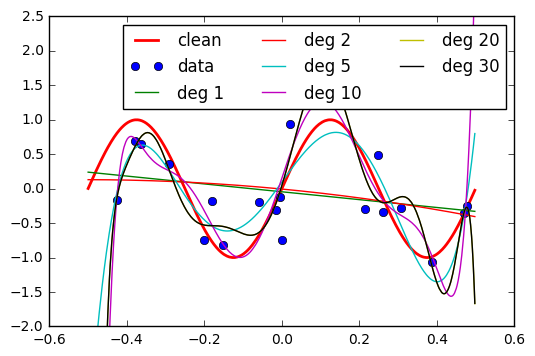

In [36]:
num = 20
lambda_=1e-15

X,Y = gen_data(num, sigma_noise=0.4)
plt.figure()
plt.plot(XC.T,YC.T,'-r', linewidth=2, label='clean')
plt.plot(X.T,Y.T,'o', label='data')
for deg in [1,2,5,10, 20, 30]:
    XE = expandX(X,deg)
    theta = polyfit(XE, Y, lambda_)
    plt.plot(XC.T, theta.T.dot(expandX(XC,deg)).T,'-', label='deg %d' % deg, )
plt.legend(loc='upper right', ncol=3)
plt.xlim([-.6, .6])
plt.ylim([-2,2.5])
plt.show()

Let us analyze how the polynomials look like for many runs:

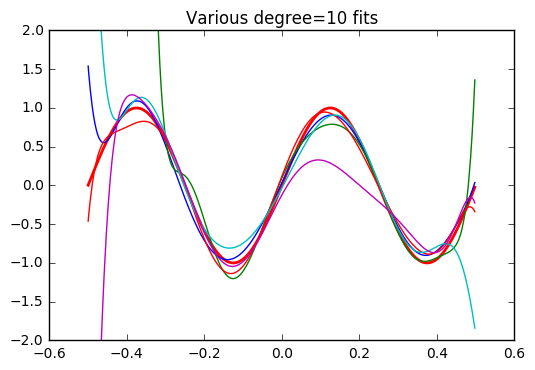

In [28]:
#Hint: change the degree and number of samples
deg = 10
num = 15
C=0 #1e-10

plt.figure()
plt.title('Various degree=%d fits' % deg)
plt.plot(XC.T, YC.T, '-r', linewidth=2, label='Clean rel.')
for run in xrange(5):
    X,Y = gen_data(num, sigma_noise=0.1)
    XE = expandX(X,deg)
    theta = polyfit(XE, Y, C)
    XCE = expandX(XC,deg)
    plt.plot(XC.T, theta.T.dot(XCE).T,'-' )

plt.xlim([-.6, .6])
plt.ylim([-2, 2])
plt.show()

We notice that there are two types of mismatch possible:

*   the **BIAS** which is the mismatch between the chosen hypothesis and real target.  
    In our case sinus does not belong to the set of polynomials. Also, polynomials of too 
    small degree cannot change monotonicity enough times.


*   the **VARIANCE** which tells how much the hypothesis chosen varies with the data.  
    In our case, the second-order polynoials had less variance than the tenth order ones

Therefore the trick to learn a good model is to:

* choose a set of hypotheses which will contain something close to the real relation in the data - maybe polynomials of degree 6?

* constrain this set to decrease the variance


Other intuitions:

* there is a link between the amount of data and the complexity of the models we can learn!
  The more data we have, the lower variance.


The same problems plague neural nets:

In [37]:
import neural_nets
reload(neural_nets)

<module 'neural_nets' from 'neural_nets.pyc'>

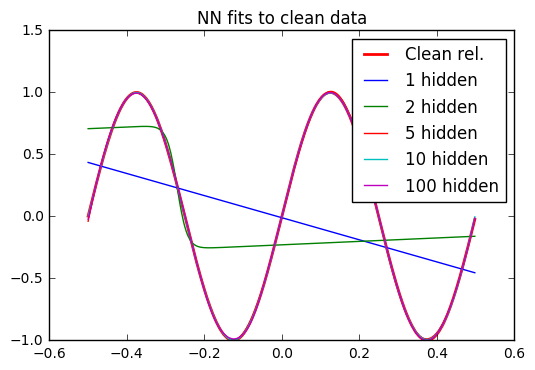

In [38]:
plt.figure()
plt.title('NN fits to clean data')
plt.plot(XC.T, YC.T, '-r', linewidth=2, label='Clean rel.')
for NN in [1,2,5,10, 100]:
    net = neural_nets.get_regression_net(XC, YC, NN)
    plt.plot(XC.T, net(XC).T,'-', label='%d hidden' % NN, )
plt.legend(loc='upper right')
plt.show()

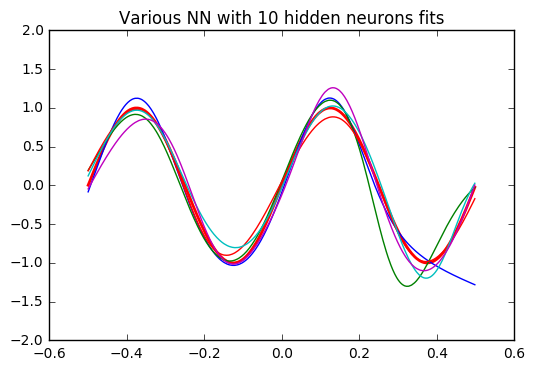

In [45]:
NN = 10
num = 20

plt.figure()
plt.title('Various NN with %d hidden neurons fits' % NN)
plt.plot(XC.T, YC.T, '-r', linewidth=2, label='Clean rel.')
for run in xrange(5):
    X,Y = gen_data(num, sigma_noise=0.1)
    net = neural_nets.get_regression_net(X, Y, NN, 0.00001)
    plt.plot(XC.T, net(XC).T,'-' )

plt.xlim([-.6, .6])
plt.ylim([-2, 2.0])
plt.show()

How to choose a good model having only the training data?


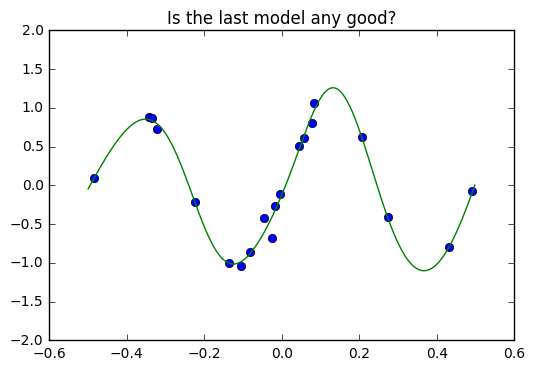

In [46]:
plt.figure()
plt.title("Is the last model any good?")
plt.plot(X.T, Y.T, 'o')
plt.plot(XC.T, net(XC).T,'-' )
plt.xlim([-.6, .6])
plt.ylim([-2, 2])
plt.show()

We need to define an **honest estimate** of the performance of our classifier.

Consider the algorithm:

    split the data into training and testing
    train on training part
    report the error on testing
    
Note: we already used this algorithm to find the value of k in k-nearest neighbors in the assignments!

In [13]:
def load_digits():
    import sklearn.datasets
    data = sklearn.datasets.load_digits()
    return data['data'].T, data['target']

In [14]:
IX, IY = load_digits()
NI = IX.shape[1]
dataperm = np.random.permutation(NI)
IX = IX[:,dataperm]
IY = IY[dataperm]

trainTh = np.round(NI*.5)
trainX = IX[:,:trainTh]
trainY = IY[:trainTh]
testX = IX[:,trainTh:]
testY = IY[trainTh:]

/pio/lscratch/1/os/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/pio/lscratch/1/os/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/pio/lscratch/1/os/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/pio/lscratch/1/os/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


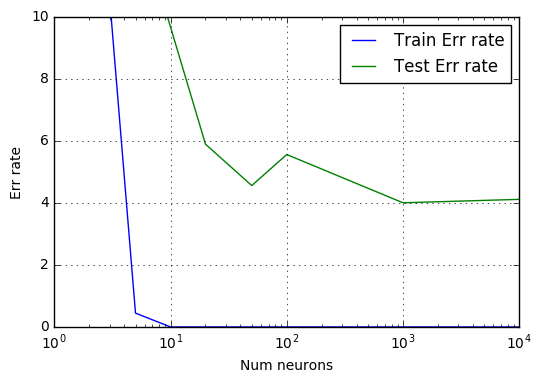

In [20]:
if 1:
    trainE = []
    testE = []
    numN = [0, 1,2,5,10,20,50,100, 1000, 10000]

    for NN in numN:
        net = neural_nets.get_class_net(trainX, trainY, NN, grad_check=False)
        trainE.append((net(trainX).argmax(0) != trainY).mean()*100.0)
        testE.append((net(testX).argmax(0) != testY).mean()*100.0)

plt.figure()
plt.semilogx(numN, trainE, numN, testE)
plt.legend(['Train Err rate','Test Err rate'])
plt.ylim(0,10)
plt.xlabel('Num neurons')
plt.ylabel('Err rate')
plt.grid()


Now we'll try to minimize the sum of squares of weights. Please observe how the variance is lowered!

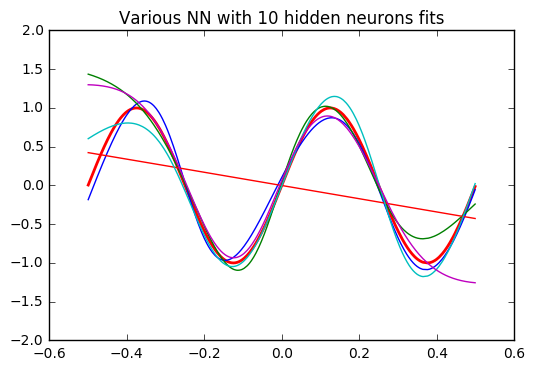

In [16]:
NN = 10
num = 20
C=1e-4

plt.figure()
plt.title('Various NN with %d hidden neurons fits' % NN)
plt.plot(XC.T, YC.T, '-r', linewidth=2, label='Clean rel.')
for run in xrange(5):
    X,Y = gen_data(num, sigma_noise=0.1)
    net = neural_nets.get_regression_net(X, Y, NN, C)
    plt.plot(XC.T, net(XC).T,'-' )

plt.xlim([-.6, .6])
plt.ylim([-2, 2.0])
plt.show()

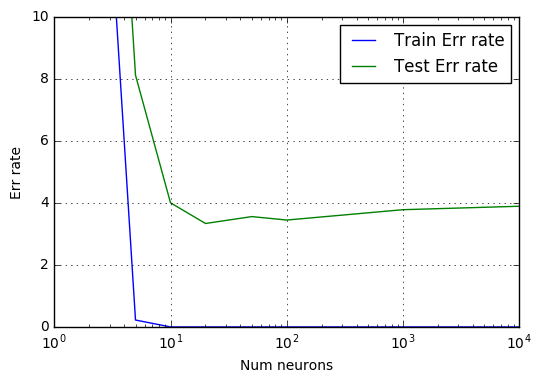

In [21]:
trainE = []
testE = []
numN = [0, 1,2,5,10,20,50,100, 1000, 10000]
C = 0.001

for NN in numN:
    net = neural_nets.get_class_net(trainX, trainY, NN, grad_check=False, wdec=C)
    trainE.append((net(trainX).argmax(0) != trainY).mean()*100.0)
    testE.append((net(testX).argmax(0) != testY).mean()*100.0)

plt.figure()
plt.semilogx(numN, trainE, numN, testE)
plt.legend(['Train Err rate','Test Err rate'])
plt.ylim(0,10)
plt.xlabel('Num neurons')
plt.ylabel('Err rate')
plt.grid()